# Trabajo Práctico N° 1

**Año:** 2024  

**Materia:** Aprendizaje Automatico 1

**Integrantes:** Avecilla Tomás, Calcia Franco



### Diccionario  de Datos

| Columna       | Descripción                                                                                          |
|---------------|---------------------------------------------------------------------------------------------------------------|
| **CRIM** | Tasa de criminalidad per cápita por ciudad.                       |
| **ZN**   | Proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados.                         |
| **INDUS**   | Proporción de acres de negocios no minoristas por ciudad.                         |
| **CHAS** | Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario).                                                             |
| **NOX**   | Concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M].                                                          |
| **RM**        | Número promedio de habitaciones por vivienda.|
| **AGE**    | Proporción de unidades ocupadas por sus propietarios construidas antes de 1940.                                                        |
| **DIS**   | Distancias ponderadas a cinco centros de empleo de Boston.       |
| **RAD** | índice de accesibilidad a las autopistas radiales.                                                             |
| **TAX**   | Tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k].                                                          |
| **PTRATIO**        | Proporción alumno-maestro por ciudad.|
| **B**    | El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad.                                                        |
| **LSTAT**   | % de población de menor estatus socioeconómico.       |
| **MEDV** *(Variable de salida)*  | Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$].   | 


# Preparacion del entorno de Trabajo

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler


In [68]:
df_precios_casas = pd.read_csv("house-prices-tp.csv")

# Train-Test
Decidimos hacer la division del dataset antes de comenzar el analisis y hacer cualquier tratado de datos ya que necesitamos que el dataset de testeo sea tomado como datos desconocidos

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df_precios_casas.drop(columns=['MEDV']), df_precios_casas['MEDV'], test_size=0.2, random_state=42)

df_entrenamiento = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

# Análisis Exploratorio

## Limpieza de Datos

### Verificamos valores nulos

In [70]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       19
ZN         18
INDUS      12
CHAS       20
NOX        21
RM         17
AGE        22
DIS        14
RAD        26
TAX        13
PTRATIO    22
B          18
LSTAT      18
MEDV       19
dtype: int64

Como primera medida eliminaremos las fila que tengan la variable de salida nula o mas de 11 columnas nulas ya que las consideramos irrelevantes para el analisis

In [71]:
filas_nan = []

for index, row in df_entrenamiento.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_entrenamiento.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")


Filas eliminadas: 19


In [72]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM        7
ZN          8
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         4
RAD        10
TAX         5
PTRATIO     5
B           6
LSTAT       6
MEDV        0
dtype: int64

Imputaremos la columna binaria con la moda

In [73]:
df_entrenamiento['CHAS'] = df_entrenamiento['CHAS'].fillna(df_entrenamiento['CHAS'].mode()[0])

Y el resto de columnas seran imputadas con KNN

In [74]:
imputer = KNNImputer(n_neighbors=5)
df_entrenamiento = pd.DataFrame(imputer.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)

In [75]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Exploracion de outliers

C:\Users\franco\AppData\Local\Temp\ipykernel_16344\490921543.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_entrenamiento, x='CHAS', palette="viridis")


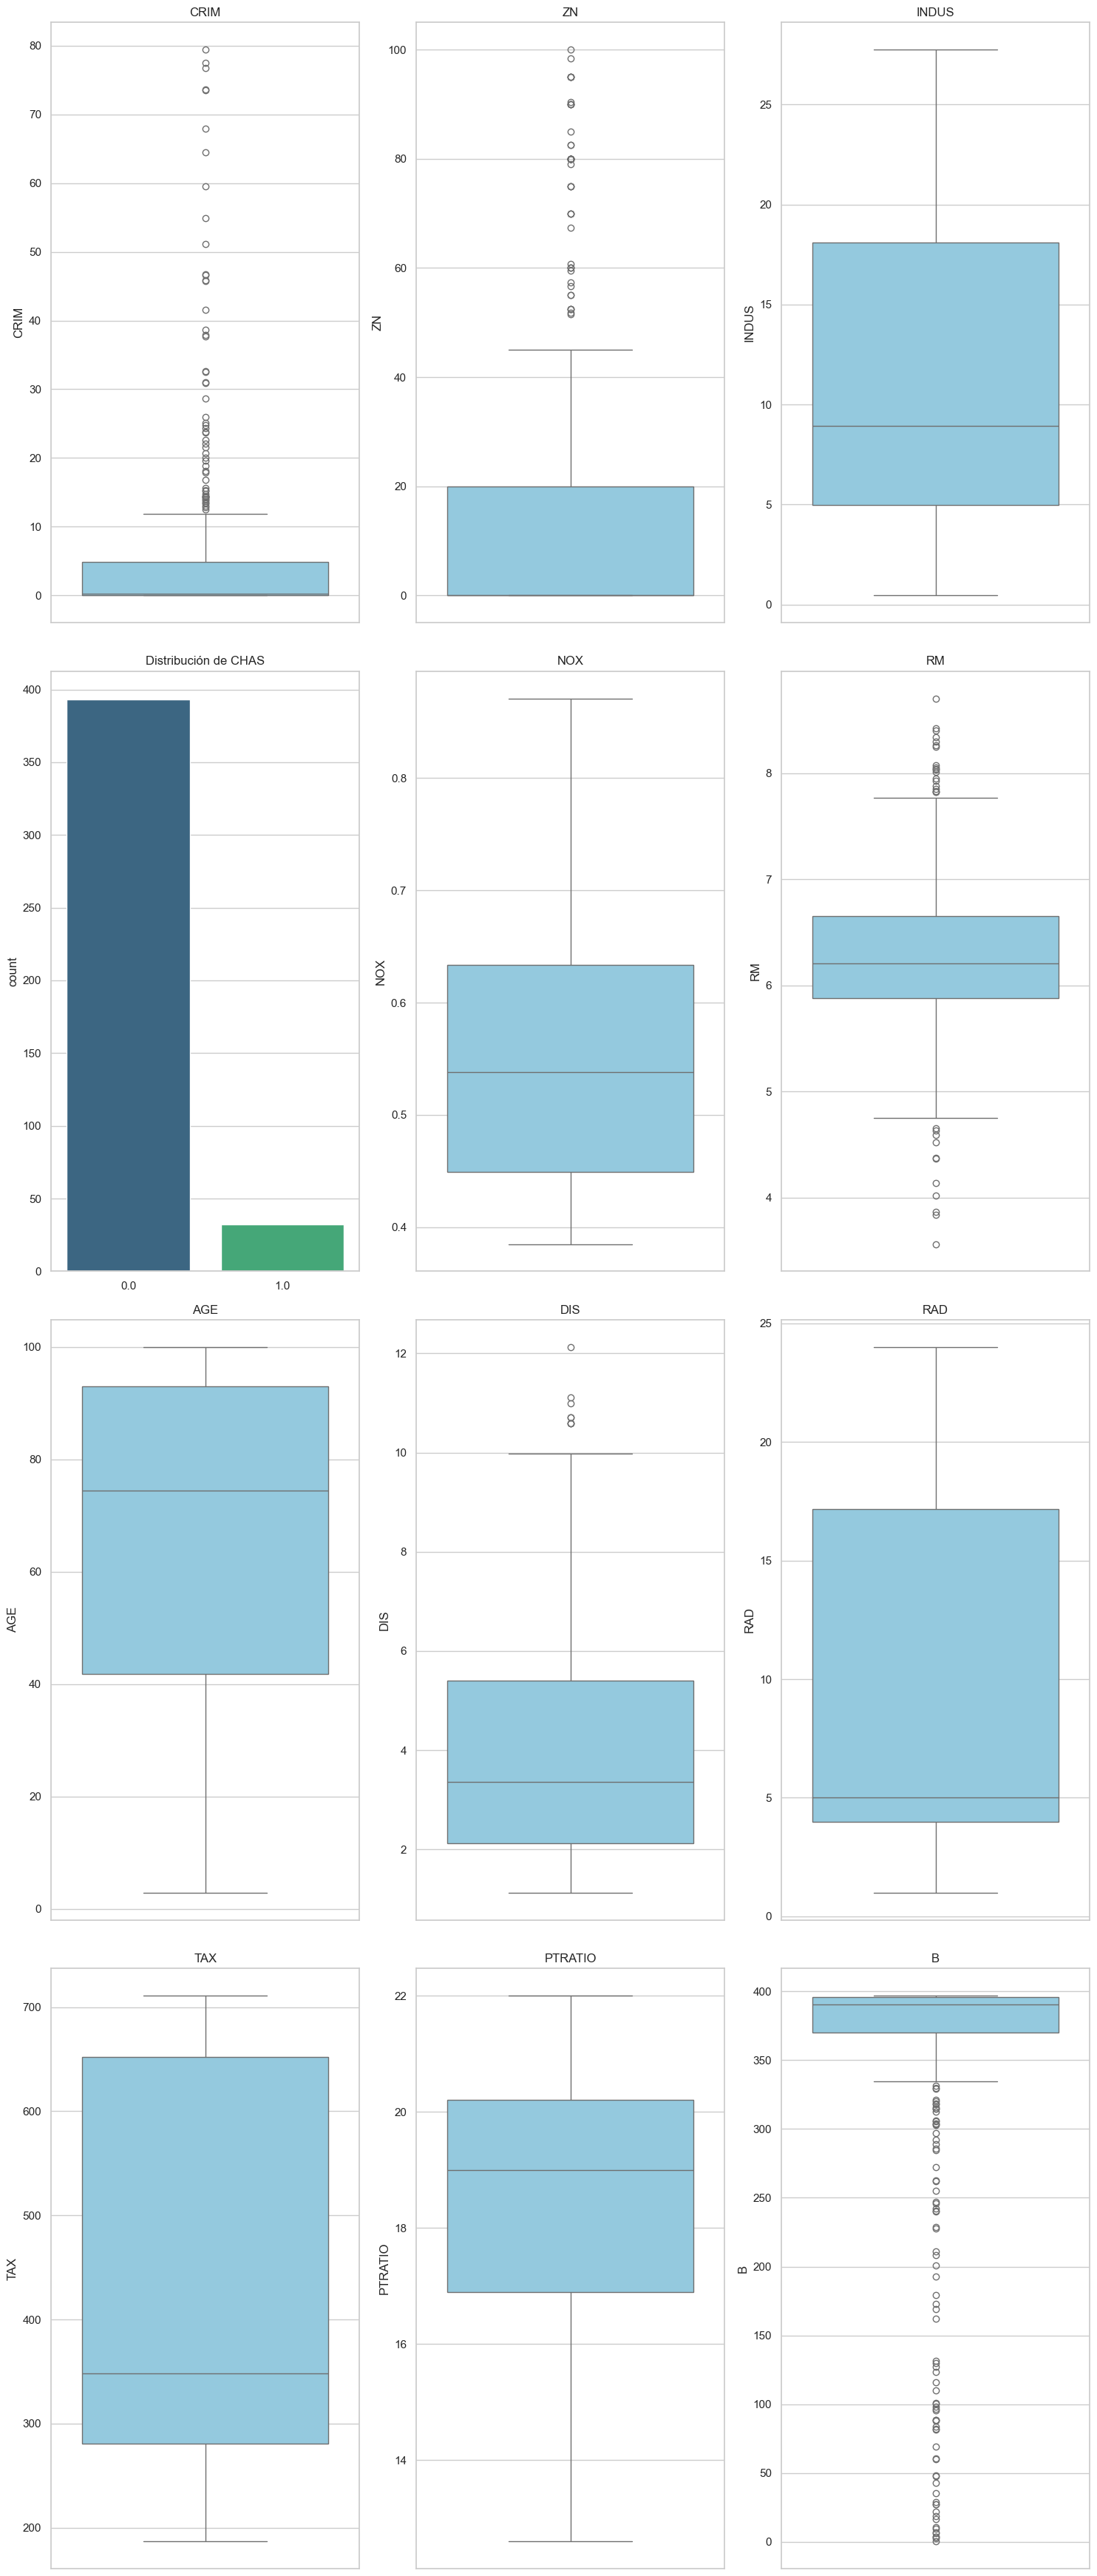

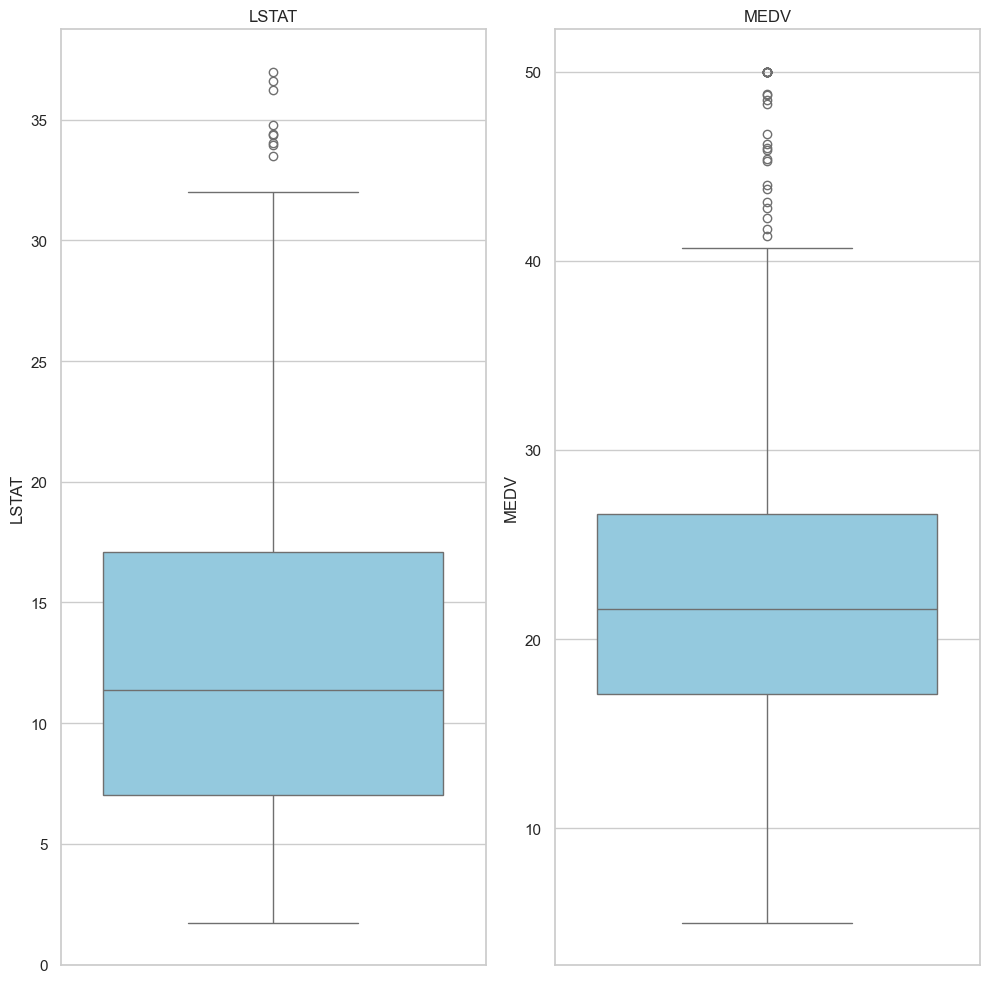

In [76]:
sns.set_theme(style="whitegrid")

num_columns = len(df_entrenamiento.columns)

max_plots_per_figure = 12
num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure

for fig_index in range(num_figures):
    start_index = fig_index * max_plots_per_figure
    end_index = min(start_index + max_plots_per_figure, num_columns)

    plt.figure(figsize=(15, 5 * ((end_index - start_index + 2) // 2)))

    for i, column in enumerate(df_entrenamiento.columns[start_index:end_index]):
        plt.subplot((end_index - start_index + 2) // 3, 3, i + 1)
        if column == 'CHAS':
            sns.countplot(data=df_entrenamiento, x='CHAS', palette="viridis")
            plt.title('Distribución de CHAS')
        else:
            sns.boxplot(data=df_entrenamiento[column], color="skyblue")
            plt.title(column)
        plt.xlabel('')

    plt.tight_layout()

    plt.show()

Podemos notar varias variables con presencia de outliers por lo cual deberiamos hacer un analisis mas profundo

In [77]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: CRIM - Porcentaje de valores atípicos: 13.18%
Columna: ZN - Porcentaje de valores atípicos: 11.76%
Columna: INDUS - Porcentaje de valores atípicos: 0.00%
Columna: CHAS - Porcentaje de valores atípicos: 7.53%
Columna: NOX - Porcentaje de valores atípicos: 0.00%
Columna: RM - Porcentaje de valores atípicos: 7.06%
Columna: AGE - Porcentaje de valores atípicos: 0.00%
Columna: DIS - Porcentaje de valores atípicos: 1.88%
Columna: RAD - Porcentaje de valores atípicos: 0.00%
Columna: TAX - Porcentaje de valores atípicos: 0.00%
Columna: PTRATIO - Porcentaje de valores atípicos: 0.00%
Columna: B - Porcentaje de valores atípicos: 18.35%
Columna: LSTAT - Porcentaje de valores atípicos: 2.12%
Columna: MEDV - Porcentaje de valores atípicos: 6.82%


## Analisis Descriptivo

In [78]:
df_entrenamiento.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,5.529209,13.888083,11.015116,0.075294,0.557949,6.268923,66.761486,3.956498,9.536218,410.502761,18.386908,347.243733,12.884819,22.929072
std,12.686008,25.441893,6.832557,0.264176,0.119567,0.742067,28.693630,2.229679,8.551540,165.365812,2.216476,99.270150,7.504014,9.406067
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.079780,0.000000,4.987915,0.000000,0.449000,5.880000,41.839732,2.124700,4.000000,281.000000,16.900000,370.220000,7.033962,17.100000
50%,0.269380,0.000000,8.937346,0.000000,0.538000,6.209000,74.400000,3.363300,5.000000,348.000000,19.000000,390.550000,11.380000,21.600000
75%,4.835670,20.000000,18.100000,0.000000,0.633879,6.649000,93.000000,5.400700,17.164570,652.148598,20.200000,395.990000,17.100000,26.600000
max,79.412097,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000,50.000000


In [79]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     425 non-null    float64
 1   ZN       425 non-null    float64
 2   INDUS    425 non-null    float64
 3   CHAS     425 non-null    float64
 4   NOX      425 non-null    float64
 5   RM       425 non-null    float64
 6   AGE      425 non-null    float64
 7   DIS      425 non-null    float64
 8   RAD      425 non-null    float64
 9   TAX      425 non-null    float64
 10  PTRATIO  425 non-null    float64
 11  B        425 non-null    float64
 12  LSTAT    425 non-null    float64
 13  MEDV     425 non-null    float64
dtypes: float64(14)
memory usage: 46.6 KB


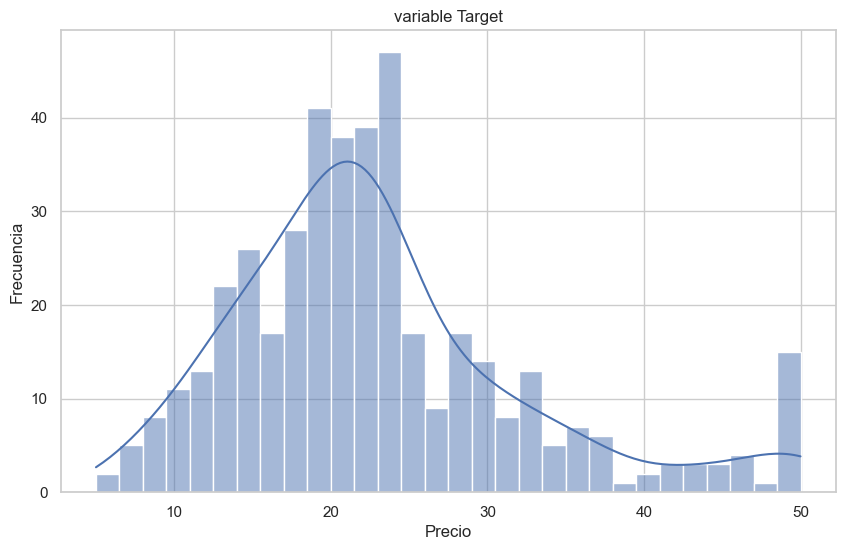

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(df_entrenamiento['MEDV'], bins=30, kde=True)
plt.title('variable Target')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now depr

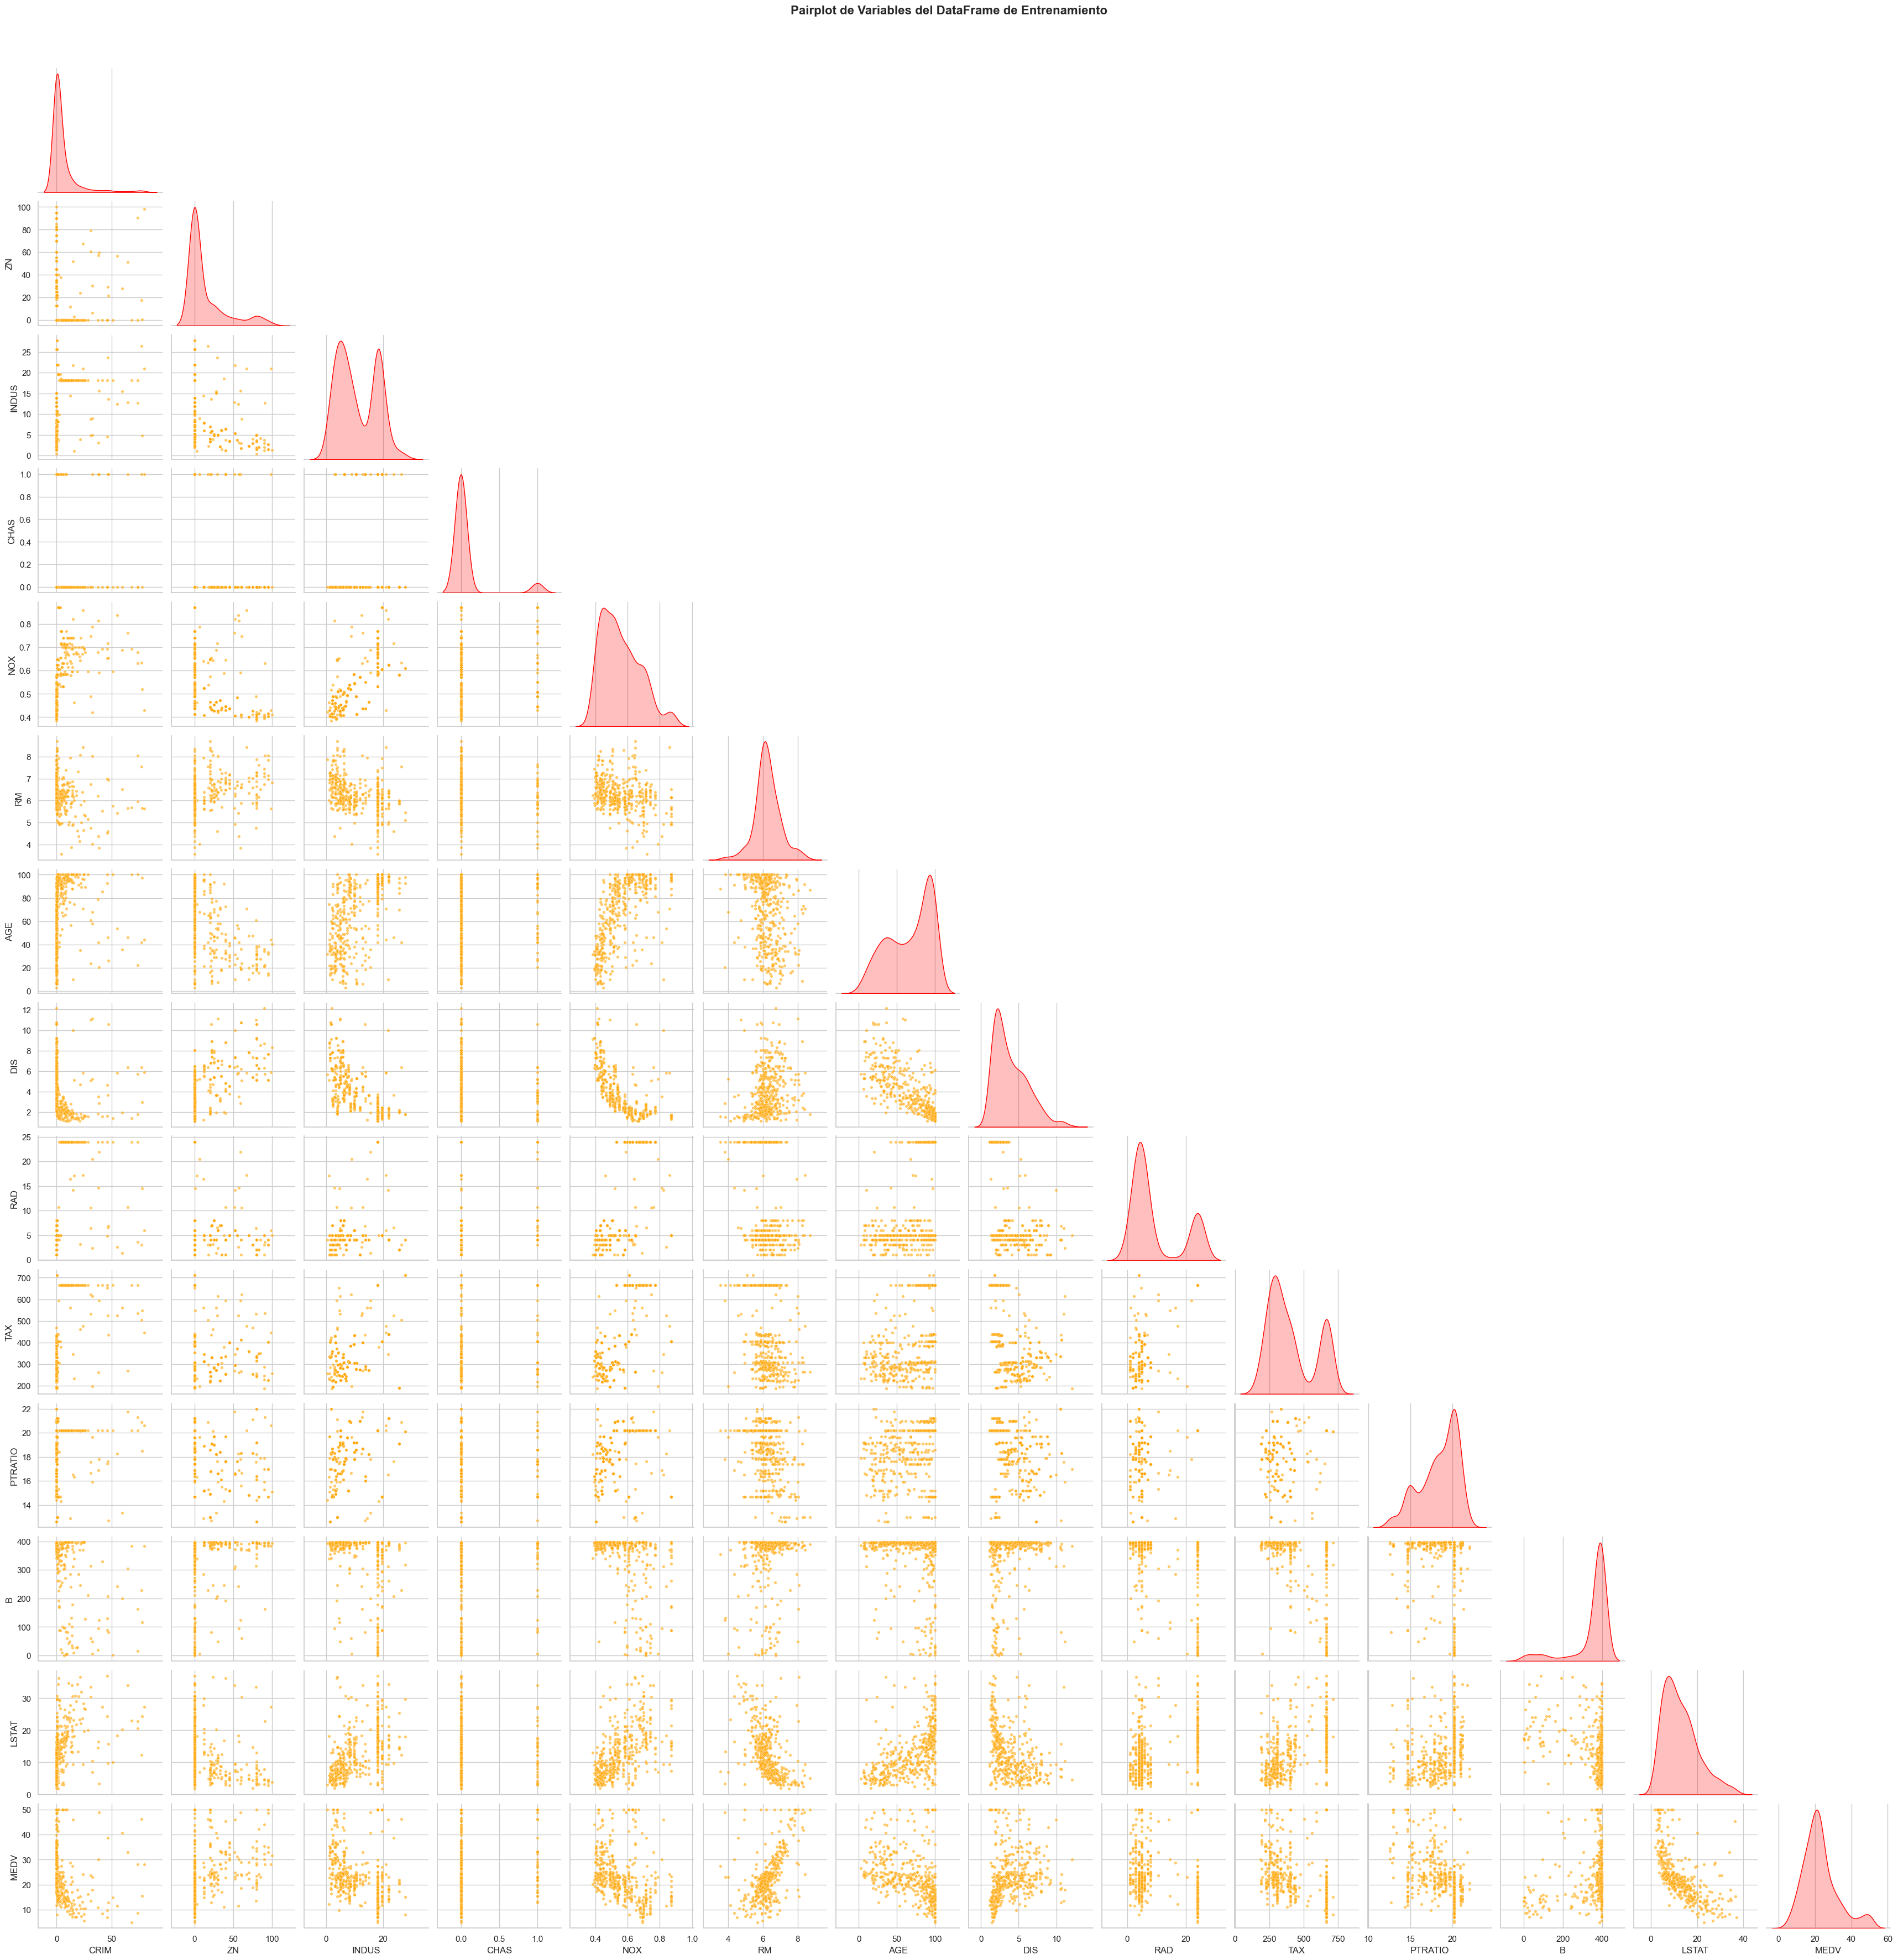

In [81]:
sns.set_theme(style="whitegrid")

sns.pairplot(
    df_entrenamiento,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 'color': 'orange', 's': 15},
    diag_kws={'color': 'red', 'shade': True},
    height=2.5,
    aspect=1,
    corner=True,
)

plt.suptitle('Pairplot de Variables del DataFrame de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)

plt.show()

#### Matriz de correlación

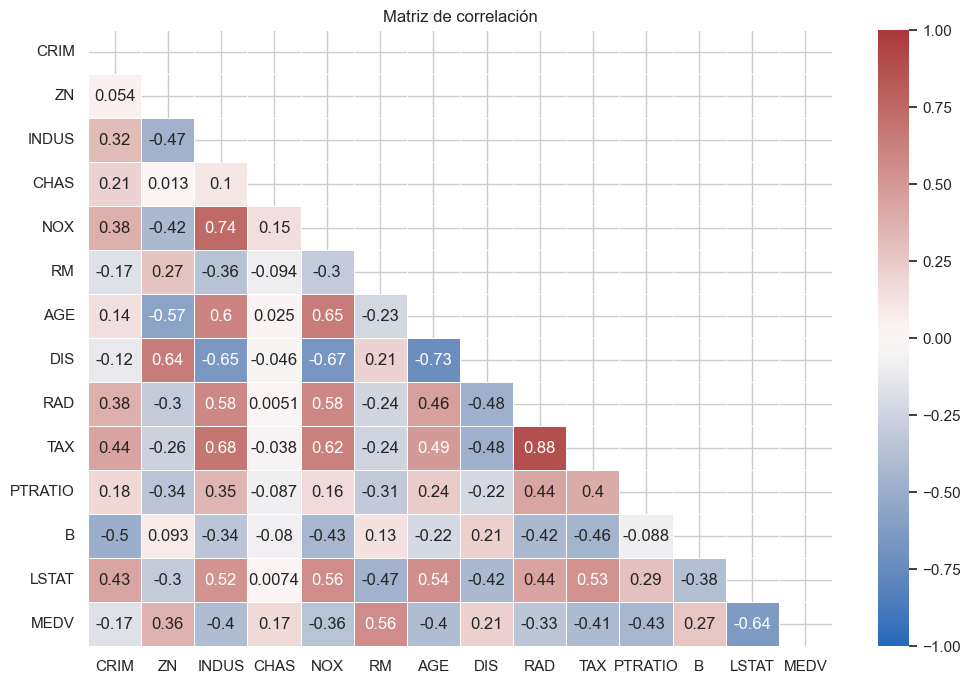

In [82]:
corr_matrix = df_entrenamiento.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Notamos una fuerte relacion entre las variables TAX-RAD (0.88) y NOX-INDUS (0.74)

# Valores nulos en dataset de testeo

In [83]:
df_test.isnull().sum()

CRIM       4
ZN         4
INDUS      3
CHAS       3
NOX        3
RM         4
AGE        2
DIS        1
RAD        2
TAX        5
PTRATIO    6
B          4
LSTAT      4
MEDV       2
dtype: int64

Usamos el mismo criterio que en el dataset de entrenamiento para eliminar filas completas

In [84]:
filas_nan = []

for index, row in df_test.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_test.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")

Filas eliminadas: 2


Aqui repetimos el criterio de rellenar con la moda que en el caso del entrenamiento fue de `0`

In [85]:
df_test['CHAS'] = df_test['CHAS'].fillna(0)

In [86]:
df_test.isnull().sum()

CRIM       4
ZN         3
INDUS      3
CHAS       0
NOX        2
RM         2
AGE        2
DIS        1
RAD        2
TAX        4
PTRATIO    4
B          3
LSTAT      3
MEDV       0
dtype: int64

Y por ultimo usamos el mismo `imputer` para rellenar los restantes

In [87]:
df_test = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

In [88]:
df_test.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

------------------------------------------------------------------------------------------------------

# Escalar los datos

In [89]:
# Separar en X_train, y_train, X_test, y_test
X_train = df_entrenamiento.drop(columns=['MEDV'])
y_train = df_entrenamiento['MEDV']
X_test = df_test.drop(columns=['MEDV'])
y_test = df_test['MEDV']

In [90]:
# Escalar los datos
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Regresión lineal simple

In [91]:
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train_scaled, y_train)

LinearRegression()

# Gradientes Descendentes

## Gradiente Descendente Estocastico (SGD)

In [92]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar el término de sesgo (bias) a las matrices de entrada
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Inicializar los pesos de forma aleatoria
    W = np.random.randn(m + 1, 1)

    train_errors = []
    test_errors = []

    # Convertir y_train y y_test a numpy.ndarray
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation].reshape(-1, 1)  # Asegurarse de que y_train sea un vector columna

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j].reshape(1, -1)
            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse[0])

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test  # Asegurarse de que y_test sea un vector columna
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T
            W = W - (lr * gradient)

            
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

## Gradiente Descendente (Batch)

In [93]:
def gradient_descent(X_train, y_train, X_val, y_val, lr, epochs):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    """
    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características

    o = X_val.shape[0]  # Número de ejemplos de validación

    # Poner columna de unos a las matrices X para el término de sesgo (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Convertir y_train y y_val a arrays de NumPy y asegurarse de que sean vectores columna
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_val = y_val.to_numpy().reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    val_errors = []    # Para almacenar el error de validación en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de validación
        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2 / n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

## Gradiente Descedente por lotes (Mini-Batch)

In [94]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs, batch_size):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

# Modelos de Regularización

In [95]:
regresiones_lineales = {
    "Lasso": LassoCV(alphas=np.logspace(-4, 4, 20), cv=5, random_state=42),
    "Ridge": RidgeCV(alphas=np.logspace(-4, 4, 20), cv=5),
    "ElasticNet": ElasticNetCV(alphas=np.logspace(-4, 4, 20), l1_ratio=np.linspace(0.1, 1, 10), cv=5, random_state=42)
}

# Evaluación de Modelos

In [96]:
def evaluar_modelo(modelo, nombre_modelo, X_train, y_train, X_test, y_test):
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    resultados = {
        "Modelo": nombre_modelo,
        "Train RMSE": mean_squared_error(y_train, y_train_pred),
        "Test RMSE": mean_squared_error(y_test, y_test_pred),
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Train MAE": mean_squared_error(y_train, y_train_pred),
        "Test MAE": mean_squared_error(y_test, y_test_pred),
        "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
        "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred)
    }

    return resultados

def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape

def evaluar_gradiente(W, X_train, X_test, y_train, y_test, nombre_modelo):
    X_train_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    y_train_pred = np.dot(X_train_bias, W).flatten()
    y_test_pred = np.dot(X_test_bias, W).flatten()

    train_mse, train_mae, train_mape = calcular_metricas(y_train, y_train_pred)
    test_mse, test_mae, test_mape = calcular_metricas(y_test, y_test_pred)

    resultados = {
        "Modelo": nombre_modelo,
        "Train RMSE": np.sqrt(train_mse),
        "Test RMSE": np.sqrt(test_mse),
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train MAPE": train_mape,
        "Test MAPE": test_mape
    }

    return resultados

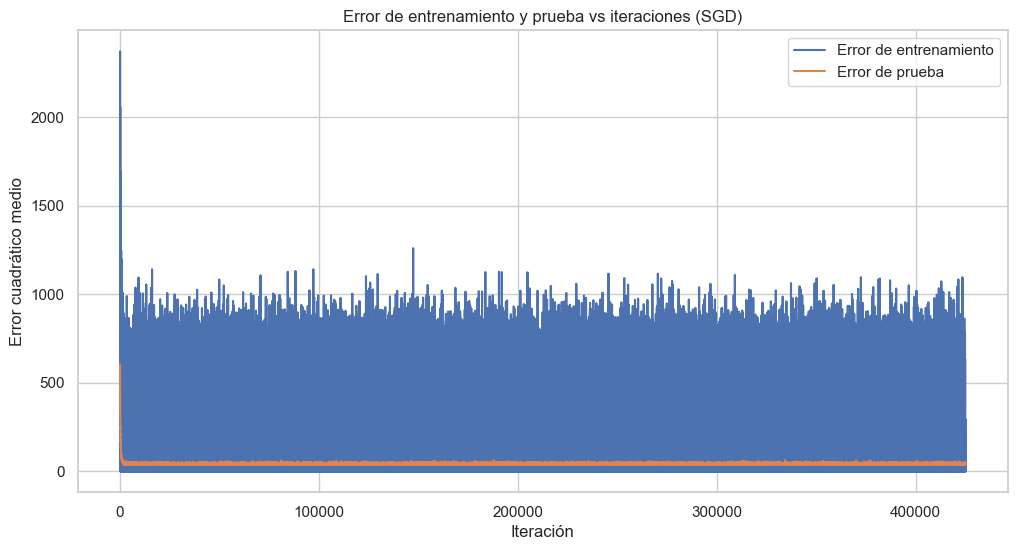

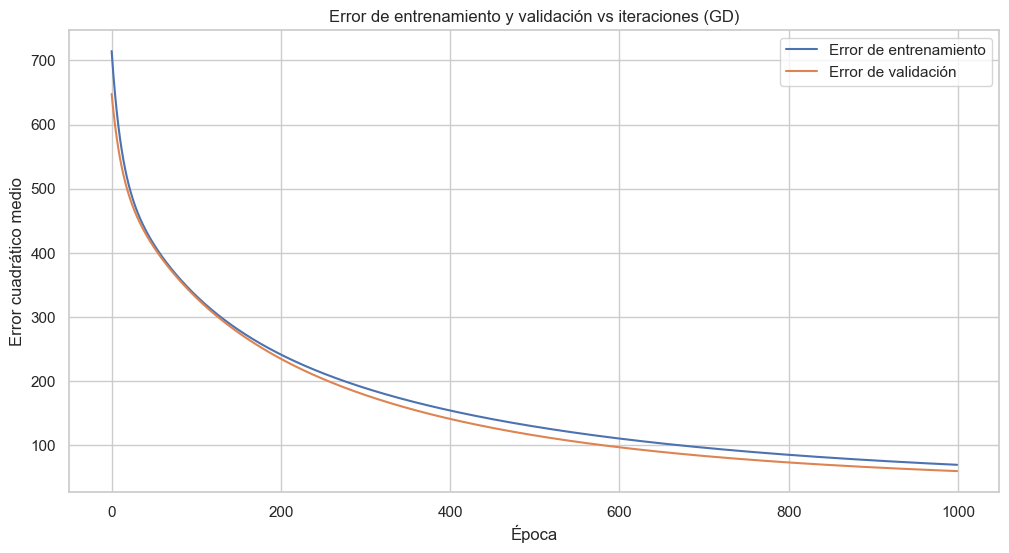

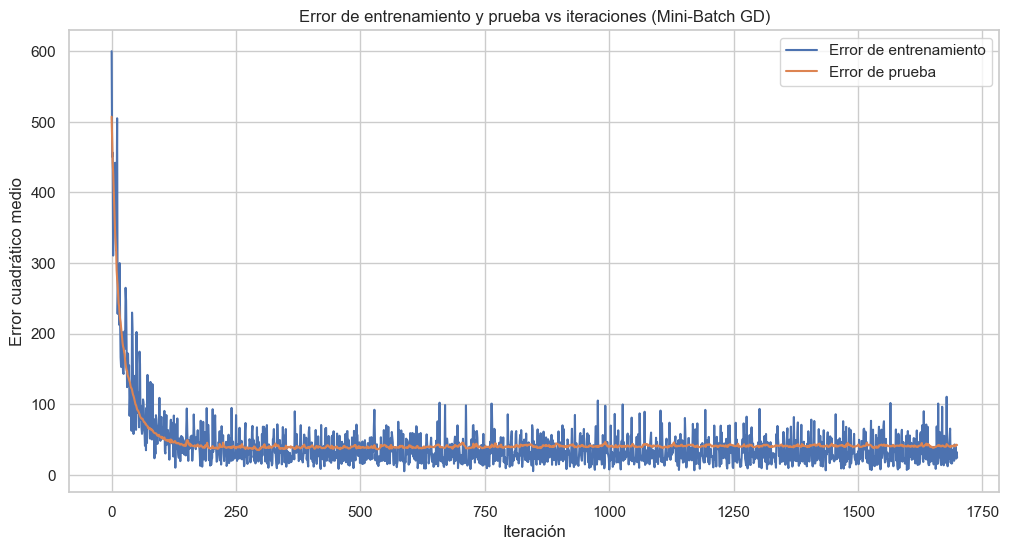

,Modelo,Train RMSE,Test RMSE,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Train MAPE,Test MAPE
0,Regresión Lineal,32.073245,40.450941,0.636629,0.577240,32.073245,40.450941,32.073245,40.450941,0.190439,0.233173
1,SGD,5.675674,6.222011,0.635043,0.595399,32.213278,38.713423,3.823158,4.164556,0.188477,0.227803
2,Batch Gradient Descent,8.312604,7.700631,0.217145,0.380248,69.099383,59.299714,6.443626,6.378179,0.295390,0.324412
3,Mini-Batch Gradient Descent,5.730970,6.509860,0.627897,0.557097,32.844015,42.378282,3.927377,4.321156,0.204113,0.248842
4,Lasso,32.089500,40.415088,0.636445,0.577615,32.089500,40.415088,32.089500,40.415088,0.190034,0.232686
5,Ridge,32.505704,40.458930,0.631730,0.577156,32.505704,40.458930,32.505704,40.458930,0.189230,0.231247
6,ElasticNet,32.570255,40.450262,0.630999,0.577247,32.570255,40.450262,32.570255,40.450262,0.189286,0.231061


In [97]:
resultados_finales = []

# Regresión lineal simple
resultados_finales.append(evaluar_modelo(regresion_lineal, "Regresión Lineal", X_train_scaled, y_train, X_test_scaled, y_test))

# Gradiente descendente (modelos obtenidos por SGD, Batch y Mini-batch)
W_sgd = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=1000)
W_batch = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=1000)
W_mini_batch = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=25)

# Evaluar los modelos obtenidos por gradientes
resultados_finales.append(evaluar_gradiente(W_sgd, X_train_scaled, X_test_scaled, y_train, y_test, "SGD"))
resultados_finales.append(evaluar_gradiente(W_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Batch Gradient Descent"))
resultados_finales.append(evaluar_gradiente(W_mini_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Mini-Batch Gradient Descent"))
# Evaluación de regularización (Lasso, Ridge, ElasticNet)
for name, regressor in regresiones_lineales.items():
    regressor.fit(X_train_scaled, y_train)
    resultados_finales.append(evaluar_modelo(regressor, name, X_train_scaled, y_train, X_test_scaled, y_test))

# Mostrar los resultados finales
resultados_df = pd.DataFrame(resultados_finales)
resultados_df.head(10)



# Interpretación de los Gráficos

## 1. Stochastic Gradient Descent (SGD)

**Análisis:**
- El error de entrenamiento es extremadamente errático, con oscilaciones muy grandes. Esto es esperado en SGD, ya que utiliza una muestra aleatoria de los datos en cada iteración, lo que genera una alta variabilidad.
- El error de prueba, por otro lado, es mucho más estable y más bajo, lo que sugiere que, a pesar de las oscilaciones del entrenamiento, el modelo generaliza bien en el conjunto de prueba.

**Conclusión:** Aunque SGD tiene un comportamiento muy volátil en el entrenamiento, parece estar generalizando bien en el conjunto de prueba. Sin embargo, esta volatilidad podría reducirse ajustando la tasa de aprendizaje o implementando técnicas como el decaimiento de la tasa de aprendizaje.

## 2. Gradient Descent (GD)

**Análisis:**
- El error disminuye rápidamente al principio y luego se estabiliza alrededor de una misma línea para el entrenamiento y la validación, lo que indica que el modelo está convergiendo de manera efectiva.
- No hay oscilaciones pronunciadas, lo cual es característico del Gradient Descent estándar, ya que utiliza todo el conjunto de datos para cada iteración.

**Conclusión:** GD muestra un comportamiento de convergencia suave y estable, con un bajo riesgo de sobreajuste, ya que los errores de entrenamiento y validación son casi idénticos.

## 3. Mini-Batch Gradient Descent (MBGD)

**Análisis:**
- El error de entrenamiento disminuye rápidamente en las primeras iteraciones, lo cual es un comportamiento esperado.
- Se observa que oscila considerablemente a lo largo de las iteraciones, lo que es típico en el Mini-Batch GD debido a la naturaleza de los lotes pequeños de datos.
- El error de prueba sigue un patrón similar pero tiene menos variabilidad, lo que sugiere que el modelo es estable en el conjunto de prueba a pesar de las oscilaciones en el entrenamiento.

**Conclusión:** Mini-Batch GD logra una rápida convergencia inicial, pero las oscilaciones indican que podría necesitar una tasa de aprendizaje más pequeña o un tamaño de lote más grande para reducir la variabilidad.

# Interpretación del Cuadro

## Regresión Lineal:
- **Train RMSE (32.07) vs. Test RMSE (40.45):** El error en el conjunto de prueba es significativamente mayor que en el de entrenamiento, lo que puede indicar que el modelo está sobreajustado.
- **Train R² (0.64) vs. Test R² (0.58):** El modelo explica el 64% de la variación en el conjunto de entrenamiento y el 58% en el conjunto de prueba, lo que sugiere una ligera disminución en la capacidad predictiva cuando se prueban datos nuevos.
- **Train MSE (32.07) vs. Test MSE (40.45):** El error cuadrático medio sigue la misma tendencia que el RMSE, con un aumento en el conjunto de prueba.
- **Train MAE (32.07) vs. Test MAE (40.45):** El error absoluto medio es bastante alto, lo que refleja un rendimiento poco preciso en la predicción.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual absoluto medio aumenta del 19% en el entrenamiento al 23% en el conjunto de prueba, lo que refleja una menor precisión predictiva.

**Conclusión:** El modelo de regresión lineal presenta un desempeño moderado, con indicios de sobreajuste y un error considerable en las predicciones.

## SGD (Stochastic Gradient Descent):
- **Train RMSE (5.68) vs. Test RMSE (6.22):** El error aumenta ligeramente en el conjunto de prueba, lo cual es normal y sugiere una buena generalización del modelo.
- **Train R² (0.65) vs. Test R² (0.60):** El modelo mantiene una alta capacidad predictiva, explicando el 65% de la variación en el conjunto de entrenamiento y el 60% en el de prueba.
- **Train MSE (32.21) vs. Test MSE (38.71):** El MSE sigue la misma tendencia que el RMSE, con un aumento moderado en el conjunto de prueba.
- **Train MAE (3.82) vs. Test MAE (4.16):** El error absoluto medio es bajo en ambos conjuntos, lo que indica una buena capacidad para realizar predicciones precisas.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual absoluto medio aumenta ligeramente en el conjunto de prueba, reflejando una pérdida leve de precisión.

**Conclusión:** El modelo SGD tiene un rendimiento sólido, generalizando bien en el conjunto de prueba y con errores menores que los modelos lineales regulares.

## Batch Gradient Descent:
- **Train RMSE (8.13) vs. Test RMSE (7.70):** El error es menor en el conjunto de prueba que en el de entrenamiento, lo cual podría indicar un posible subajuste del modelo.
- **Train R² (0.22) vs. Test R² (0.38):** El modelo mejora su capacidad predictiva en el conjunto de prueba, lo que sugiere que no está aprendiendo adecuadamente de los datos de entrenamiento.
- **Train MSE (69.10) vs. Test MSE (59.30):** El error cuadrático medio es mayor en el conjunto de entrenamiento que en el de prueba, lo cual sigue la tendencia del RMSE.
- **Train MAE (6.38) vs. Test MAE (6.29):** El error absoluto medio es similar en ambos conjuntos.
- **Train MAPE (0.29) vs. Test MAPE (0.32):** El error porcentual absoluto medio es moderadamente mayor en el conjunto de prueba.

**Conclusión:** El modelo Batch Gradient Descent parece estar subajustado, lo que resulta en un mejor rendimiento en el conjunto de prueba que en el de entrenamiento.

## Mini-Batch Gradient Descent:
- **Train RMSE (5.73) vs. Test RMSE (6.51):** El error aumenta en el conjunto de prueba, pero sigue siendo bastante bajo, lo que sugiere una buena generalización.
- **Train R² (0.63) vs. Test R² (0.57):** El modelo mantiene una capacidad predictiva sólida, explicando el 63% de la variación en el conjunto de entrenamiento y el 57% en el de prueba.
- **Train MSE (32.84) vs. Test MSE (42.38):** El MSE sigue la misma tendencia que el RMSE, con un aumento en el conjunto de prueba.
- **Train MAE (3.93) vs. Test MAE (4.32):** El error absoluto medio es bajo en ambos conjuntos.
- **Train MAPE (0.20) vs. Test MAPE (0.25):** El error porcentual absoluto medio aumenta ligeramente en el conjunto de prueba.

**Conclusión:** El modelo Mini-Batch Gradient Descent ofrece un buen equilibrio entre ajuste y generalización, con errores relativamente bajos y consistentes.

## Lasso:
- **Train RMSE (32.09) vs. Test RMSE (40.42):** Los errores son muy similares a los de la regresión lineal, sin una mejora significativa.
- **Train R² (0.64) vs. Test R² (0.58):** La capacidad predictiva es prácticamente idéntica a la de la regresión lineal, lo que indica que la regularización no tuvo un impacto considerable.
- **Train MSE (32.09) vs. Test MSE (40.42):** Consistente con el RMSE.
- **Train MAE (32.09) vs. Test MAE (40.42):** Los errores absolutos medios son altos en ambos conjuntos.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual absoluto medio es similar al de la regresión lineal.

**Conclusión:** El modelo Lasso no mejora significativamente respecto a la regresión lineal, indicando que la regularización no es efectiva en este caso.

## Ridge:
- **Train RMSE (32.51) vs. Test RMSE (40.46):** El error en ambos conjuntos es alto y no muestra una mejora significativa en comparación con la regresión lineal.
- **Train R² (0.63) vs. Test R² (0.58):** La capacidad predictiva es similar a la de la regresión lineal y Lasso.
- **Train MSE (32.51) vs. Test MSE (40.46):** Consistente con el RMSE.
- **Train MAE (32.51) vs. Test MAE (40.46):** Los errores absolutos medios son altos.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual absoluto medio sigue la tendencia de los otros modelos.

**Conclusión:** Ridge no mejora el rendimiento en comparación con los otros modelos, lo que sugiere que la regularización L2 no es beneficiosa en este contexto.

## ElasticNet:
- **Train RMSE (32.57) vs. Test RMSE (40.45):** El error es prácticamente idéntico al de Lasso y Ridge.
- **Train R² (0.63) vs. Test R² (0.58):** Capacidad predictiva similar a los demás modelos regularizados.
- **Train MSE (32.57) vs. Test MSE (40.45):** Consistente con el RMSE.
- **Train MAE (32.57) vs. Test MAE (40.45):** Errores absolutos medios altos en ambos conjuntos.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual es el mismo que en los otros modelos de regularización.

**Conclusión:** ElasticNet no mejora el rendimiento respecto a Lasso o Ridge, lo que sugiere que la combinación de penalizaciones L1 y L2 no aporta beneficios en este caso.

---

# Conclusión parcial:
- **Modelos de Regularización (Lasso, Ridge, ElasticNet) y Regresión Lineal:**
  - Presentan errores similares en los conjuntos de datos.
  - La regularización no mejora significativamente el rendimiento, lo que sugiere que estos modelos no capturan adecuadamente la complejidad de los datos.

- **Modelos Basados en Gradiente:**
  - **SGD y Mini-Batch Gradient Descent** ofrecen un rendimiento superior, con mejores métricas de error y capacidad predictiva.
  - **Batch Gradient Descent** parece estar subajustado, con mejor rendimiento en el conjunto de prueba que en el de entrenamiento.

- **General:**
  - Los métodos de gradiente, en particular **Mini-Batch Gradient Descent**, logran un buen equilibrio entre ajuste y generalización, mientras que los modelos de regularización no muestran mejoras claras.
---

# Optimización de los hiperparámetros.

In [98]:
regresiones_lineales = {
    "Lasso": LassoCV(alphas=np.logspace(-6, 2, 50), cv=5, max_iter=10000),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 2, 50), cv=5),
    "ElasticNet": ElasticNetCV(alphas=np.logspace(-4, 4, 20), l1_ratio=np.linspace(0.1, 1, 10), cv=5, random_state=42)
}

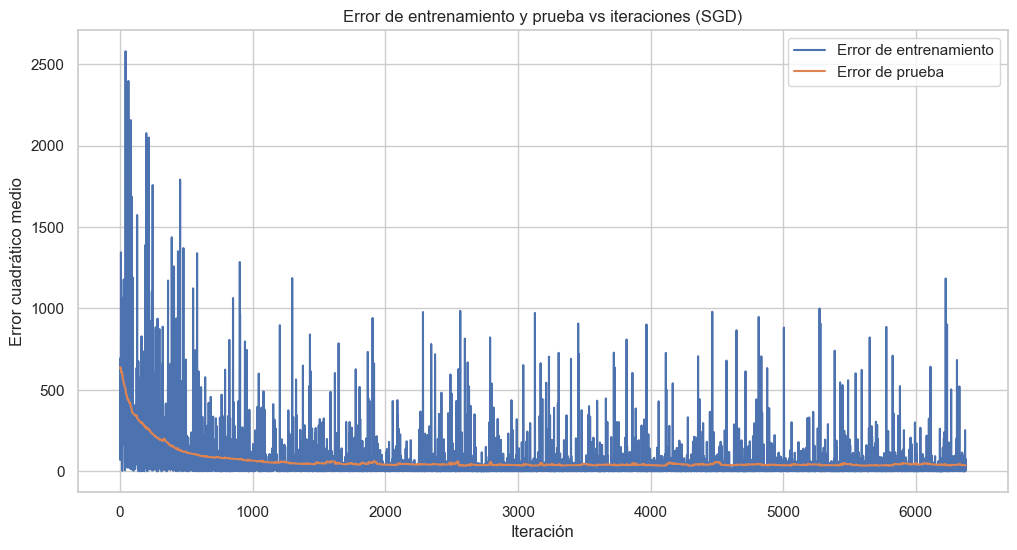

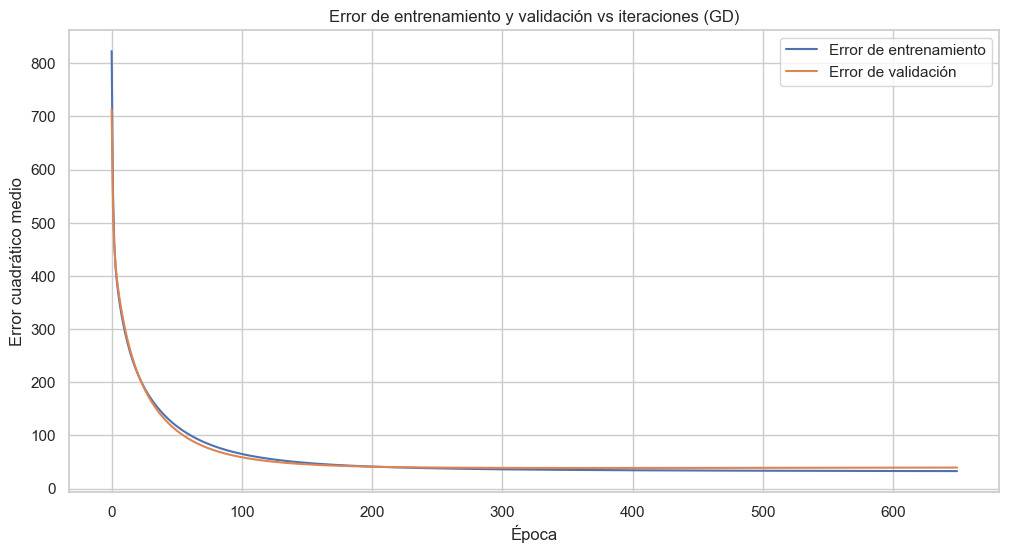

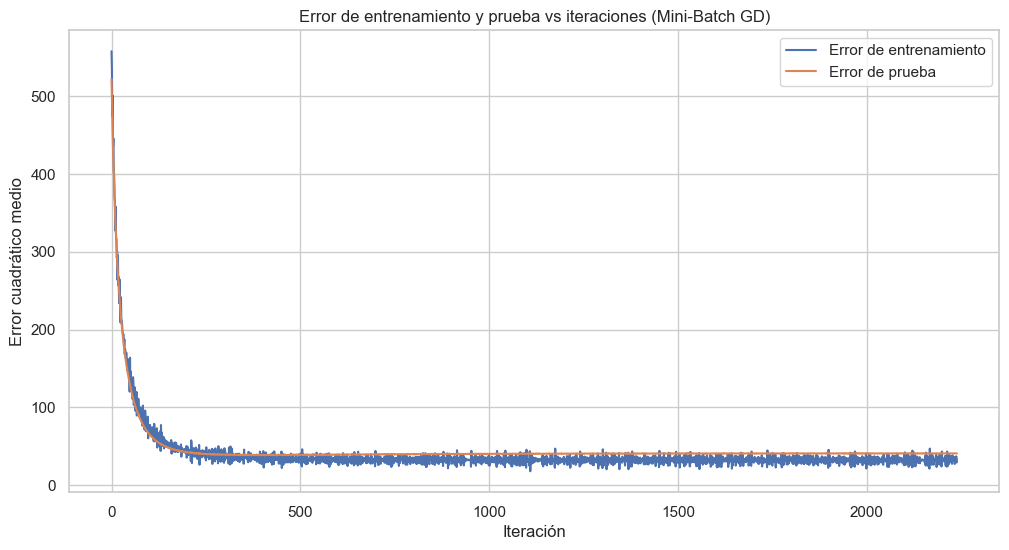

,Modelo,Train RMSE,Test RMSE,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE,Train MAPE,Test MAPE
0,Regresión Lineal,32.073245,40.450941,0.636629,0.577240,32.073245,40.450941,32.073245,40.450941,0.190439,0.233173
1,SGD,5.769656,6.088682,0.622856,0.612553,33.288934,37.072045,3.815853,4.029742,0.185168,0.220566
2,Batch Gradient Descent,5.734206,6.286787,0.627477,0.586931,32.881116,39.523695,3.835279,4.105887,0.191546,0.230287
3,Mini-Batch Gradient Descent,5.664245,6.380834,0.636511,0.574480,32.083676,40.715038,3.817228,4.210310,0.190767,0.233904
4,Lasso,32.104143,40.412669,0.636279,0.577640,32.104143,40.412669,32.104143,40.412669,0.189921,0.232644
5,Ridge,32.461222,40.468791,0.632234,0.577053,32.461222,40.468791,32.461222,40.468791,0.189222,0.231419
6,ElasticNet,32.570255,40.450262,0.630999,0.577247,32.570255,40.450262,32.570255,40.450262,0.189286,0.231061


In [99]:
resultados_finales = []

# Regresión lineal simple
resultados_finales.append(evaluar_modelo(regresion_lineal, "Regresión Lineal", X_train_scaled, y_train, X_test_scaled, y_test))

# Gradiente descendente (modelos obtenidos por SGD, Batch y Mini-batch)
W_sgd = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=15)
W_batch = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=650)
W_mini_batch = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=1120, batch_size=240)

# Evaluar los modelos obtenidos por gradientes
resultados_finales.append(evaluar_gradiente(W_sgd, X_train_scaled, X_test_scaled, y_train, y_test, "SGD"))
resultados_finales.append(evaluar_gradiente(W_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Batch Gradient Descent"))
resultados_finales.append(evaluar_gradiente(W_mini_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Mini-Batch Gradient Descent"))
# Evaluación de regularización (Lasso, Ridge, ElasticNet)
for name, regressor in regresiones_lineales.items():
    regressor.fit(X_train_scaled, y_train)
    resultados_finales.append(evaluar_modelo(regressor, name, X_train_scaled, y_train, X_test_scaled, y_test))

# Mostrar los resultados finales
resultados_df = pd.DataFrame(resultados_finales)
resultados_df.head(10)


# Comparación de Códigos y Resultados Obtenidos

## Cambios en el código

### 1. Parámetros de Lasso y Ridge:

- **Lasso:**
  - En el primer código, el rango de `alpha` es más reducido `(np.logspace(-4, 4, 20))`, mientras que en el segundo código, se expandió para cubrir un rango más amplio `(np.logspace(-6, 2, 50))`, lo cual permite encontrar una mejor regularización en escenarios donde un ajuste fino es necesario.
  - Además, en el segundo código, se aumentó `max_iter` a `10,000` en Lasso, lo que permite más iteraciones y mayor tiempo para que el algoritmo converja en casos difíciles.

- **Ridge:**
  - En el primer código, el rango de `alpha` también es más estrecho `(np.logspace(-4, 4, 20))`, mientras que en el segundo se incrementa a un rango más amplio de `np.logspace(-6, 2, 50)`. Esto da mayor flexibilidad en la búsqueda del valor óptimo de regularización.

### 2. Parámetros de los Gradientes:

- **SGD:**
  - En la primera configuración: `epochs=1000` y `lr=0.001`.
  - En la segunda configuración: `epochs=15` y `lr=0.001`. La reducción significativa en el número de épocas muestra mejoras importantes en los resultados, sugiriendo que un menor número de iteraciones permitió evitar el sobreajuste.

- **Batch Gradient Descent:**
  - Primera configuración: `epochs=1000` y `lr=0.001`.
  - Segunda configuración: `epochs=650` y `lr=0.01`. Aumentar la tasa de aprendizaje junto con la reducción en las épocas mostró mejoras significativas tanto en el conjunto de entrenamiento como en el de prueba.

- **Mini-Batch Gradient Descent:**
  - Primera configuración: `epochs=100`, `lr=0.01`, y `batch_size=25`.
  - Segunda configuración: `epochs=1120`, `lr=0.01`, y `batch_size=240`. Aunque el número de épocas y el tamaño del batch cambiaron considerablemente, los resultados no muestran variaciones significativas entre ambas configuraciones.

## Comparación de Resultados

| Modelo                        | Train RMSE (Antes) | Train RMSE (Después) | Test RMSE (Antes) | Test RMSE (Después) | Train R2 (Antes) | Train R2 (Después) | Test R2 (Antes) | Test R2 (Después) |
|-------------------------------|--------------------|----------------------|-------------------|---------------------|------------------|--------------------|-----------------|-------------------|
| **SGD**                        | 5.6756             | 5.7697               | 6.2220            | 6.0887              | 0.6350           | 0.6229             | 0.5954          | 0.6125            |
| **Batch Gradient Descent**      | 8.3126             | 5.7342               | 7.7006            | 6.2868              | 0.2171           | 0.6275             | 0.3802          | 0.5869            |
| **Mini-Batch Gradient Descent** | 5.7310             | 5.6642               | 6.5099            | 6.3808              | 0.6279           | 0.6365             | 0.5751          | 0.5745            |
| **Lasso**                      | 32.0895            | 32.1041              | 40.4151           | 40.4127             | 0.6364           | 0.6363             | 0.5776          | 0.5776            |
| **Ridge**                      | 32.5057            | 32.4612              | 40.4589           | 40.4688             | 0.6317           | 0.6322             | 0.5772          | 0.5771            |

## Evaluación de los Resultados:

- **SGD:**
  La reducción de épocas mejoró los resultados en el conjunto de prueba. El Test RMSE bajó de 6.22 a 6.09, y el Test R2 subió de 0.595 a 0.612. Esto sugiere que la modificación de hiperparámetros fue efectiva para evitar el sobreajuste en este modelo.

- **Batch Gradient Descent:**
  Se observa una mejora importante en los resultados de entrenamiento y prueba. El Train RMSE mejoró considerablemente de 8.31 a 5.73, y el Test RMSE bajó de 7.70 a 6.29. El ajuste en los hiperparámetros claramente favoreció un mejor rendimiento del modelo.

- **Mini-Batch Gradient Descent:**
  Los cambios en los hiperparámetros no causaron una mejora significativa en el rendimiento. El Test RMSE y el Test R2 se mantuvieron bastante similares entre ambas configuraciones.

- **Lasso y Ridge:**
  Los modelos regularizados apenas mostraron diferencias en sus métricas, lo que indica que los cambios en los hiperparámetros no afectaron de manera sustancial el rendimiento.


# Comparación de Modelos

Para determinar cuál es el mejor modelo de regresión, usaremos como métrica principal el **RMSE** (Root Mean Squared Error) en el conjunto de **prueba**, ya que mide la magnitud de los errores en la predicción y nos permite identificar qué tan bien el modelo generaliza en datos no vistos. También consideraremos el **R²**, que nos indica qué proporción de la variabilidad de la variable dependiente es explicada por el modelo.

#### Resumen de las métricas clave:
- **Regresión Lineal**:
  - Test RMSE: 40.45
  - Test R²: 0.58
- **SGD**:
  - Test RMSE: 6.09
  - Test R²: 0.61
- **Batch Gradient Descent**:
  - Test RMSE: 6.29
  - Test R²: 0.59
- **Mini-Batch Gradient Descent**:
  - Test RMSE: 6.38
  - Test R²: 0.57
- **Lasso**:
  - Test RMSE: 40.41
  - Test R²: 0.58
- **Ridge**:
  - Test RMSE: 40.47
  - Test R²: 0.58
- **ElasticNet**:
  - Test RMSE: 40.45
  - Test R²: 0.58

#### Análisis:
1. **SGD** tiene el mejor **RMSE** en el conjunto de prueba con un valor de **6.09**, lo que significa que tiene el menor error de predicción entre todos los modelos. Su **R²** de **0.61** indica que explica el 61% de la variabilidad en el conjunto de prueba, lo cual es el mayor valor entre los modelos probados.

2. **Batch Gradient Descent** muestra un **RMSE** cercano de **6.29**, con un **R²** de **0.59**, lo que significa que también tiene un buen rendimiento en la predicción, aunque ligeramente inferior al de SGD.

3. **Mini-Batch Gradient Descent** tiene un **RMSE** de **6.38** y un **R²** de **0.57**, lo que lo sitúa muy cerca de los otros métodos de gradiente descendente, con un error algo mayor pero aún competitivo.

4. Los modelos tradicionales de regresión regularizada como **Lasso**, **Ridge**, **ElasticNet**, y la **Regresión Lineal** tienen RMSEs significativamente más altos, todos alrededor de **40.45**, lo que sugiere que estos modelos no generalizan tan bien como los métodos de gradiente en este conjunto de datos. Sin embargo, su **R²** es razonable (0.58), lo que indica que explican una parte importante de la variabilidad de los datos, pero sus errores absolutos son mucho mayores.

#### Conclusión:
El modelo **SGD (Stochastic Gradient Descent)** es el mejor en este caso, con el menor **Test RMSE** (6.09) y el mayor **R²** (0.61), lo que lo hace el más adecuado para este conjunto de datos. Sin embargo, los modelos **Batch Gradient Descent** y **Mini-Batch Gradient Descent** también ofrecen un buen rendimiento, aunque con ligeros aumentos en el error de predicción. Los modelos tradicionales como la Regresión Lineal, Lasso, Ridge, y ElasticNet no parecen ser los más óptimos, dado su mayor RMSE.


# Conclusión final del trabajo

Este proyecto de análisis de precios de casas se centró en la preparación de datos, manejo de valores atípicos, imputación de valores faltantes y comparación de múltiples enfoques de regresión para predecir el valor de una vivienda (variable objetivo "MEDV").

1. **Preprocesamiento de datos**: 
   - La eliminación de filas con un alto número de valores faltantes,esto se hizo para garantizar la calidad de los datos. Se implementó un método de imputación KNN para manejar valores faltantes, lo que ayudó a preservar las observaciones al completar las características faltantes con datos similares.

2. **Análisis exploratorio**:
   - Los análisis gráficos como los boxplots y pairplots permitieron identificar la distribución de las variables y observar posibles correlaciones entre ellas. Este tipo de visualización fue útil para detectar posibles relaciones entre las variables explicativas y la variable objetivo, lo cual guió la elección de los modelos.

3. **Modelado y evaluación**:
   - Se implementaron múltiples técnicas de regresión lineal regularizada, como Ridge, Lasso y ElasticNet, junto con modelos de gradiente descendente (GD, SGD, y Mini-Batch GD). Estos modelos se ajustaron usando datos escalados para mejorar la convergencia y la estabilidad de los coeficientes del modelo.
   - Los resultados se evaluaron utilizando métricas como el MSE (Error Cuadrático Medio), MAE (Error Absoluto Medio), y MAPE (Porcentaje de Error Absoluto Medio), lo que permitió comparar el rendimiento entre los distintos enfoques.
   - Se implementaron gráficos para visualizar los errores de entrenamiento y prueba a lo largo de las iteraciones, lo que permitió un monitoreo visual de la optimización del modelo.

4. **Comparación de resultados**:
   - Los modelos con regresión regularizada como Ridge y ElasticNet mostraron un buen equilibrio entre evitar el sobreajuste y mantener una buena capacidad predictiva, con bajos valores de MAPE y R² decentes tanto en los conjuntos de entrenamiento como de prueba.
   - Los algoritmos de gradiente descendente (GD, SGD, Mini-Batch GD) mostraron ser efectivos en la optimización, aunque con un mayor costo computacional debido a la necesidad de ajustar parámetros como la tasa de aprendizaje y el tamaño del lote.

### Reflexiones finales:
Este análisis permitió demostrar cómo distintas técnicas de modelado pueden abordar problemas de regresión con eficacia, especialmente cuando se aplican correctamente los pasos de preprocesamiento y selección de modelos. La integración de modelos como Lasso y Ridge junto con técnicas de gradiente descendente proporcionó una visión completa de los enfoques lineales para predicción.
En conclusión, la combinación de métodos de imputación, detección de valores atípicos y la aplicación de distintos modelos de regresión permite realizar un análisis robusto y mejorar la precisión en la predicción de precios de casas.